# Assignment 5: Improving the Pipeline - Updated

## Part 2: Analysis

The problem is to predict if a project on donorschoose will not get fully funded within 60 days of posting. This prediction is being done at the time of posting, so you can only use data available to you at that time. The data is a file that has one row for each project posted with a column for "date_posted" (the date the project was posted) and a column for "datefullyfunded" (the date the project was fully funded - assumption for this assignment is that all projects were fully funded eventually). The task is to predict if a project on donorschoose will not get fully funded within 60 days of posting.

The data spans Jan 1, 2012 to Dec 31, 2013. You should have your validation/test set be a rolling window of 6 months (which should give you three test sets). The training sets should be everything from 1/1/12 to the beginning of the test set.

In [1]:
import pipeline_v3 as pipeline
import pandas as pd
import numpy as np
import warnings

from sklearn.model_selection import ParameterGrid

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier 
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
warnings.filterwarnings('ignore')

First, I specify the necessary parameters to apply the pipeline. This includes specifying the target variable (not_funded_within_60days) and feature variables. Note, I used included all of the potentially meaningful features included in the original data. My pipeline pre-processes these data by (1) converting the categorical variables into dummy variables (using a one-hot-encoding approach), and (2) imputing missing values using the mean of the column. This is done for the training and testing data separately. 

I also specify the necessary parameters for the temporal splits– the start and end dates for the splits, along with the test window and prediction window. With this information, I calculate the number of splits in the data (i.e., the number of temporal splits to loop over). As specified in the instructions, the validation sets are 6 month windows, where the training sets are everything from the start date to the beginning of the test set after leaving a gap for the prediction window of 60 days between the two.  

I then specify the models to run (per the instructions, Logistic Regrssion, K-Nearest Neighbor, Decision Trees, SVM, Random Forests (a type of Bagging), and two Boosting classifiers (Gradient Boosting and AdaBoost), along with the parameters to vary for each of these classifiers. 

Finally, I specify the necessary evaluation parameters– the k-percentage thresholds and the name of the CSV file to output the final evaluation table to. As specified in the instructions, my evaluation table includes the following metrics (all at a k-percentage threshold): accuracy, precision, recall, F1 and AUC_ROC). 

In [2]:
# Define target 
target_col = 'not_funded_within_60days'

# Define features 
feature_cols = ['school_city', 
                'school_state', 
                'school_metro', 
                'school_county',
                'school_charter', 
                'school_magnet',
                'teacher_prefix',
                'primary_focus_subject', 
                'primary_focus_area', 
                'resource_type',
                'poverty_level', 
                'grade_level', 
                'total_price_including_optional_support', 
                'students_reached', 
                'eligible_double_your_impact_match']

# Define temporal splits 
start_date = '2012-01-01'
end_date = '2013-12-31'
test_window = pd.Timedelta(6, unit='M')
prediction_horizon = pd.Timedelta(60, unit='d') 
splits = pd.Timedelta(pd.to_datetime(end_date) - pd.to_datetime(start_date)) // test_window
date_col = 'date_posted'

# Define models
classifiers = {'LR':  LogisticRegression(),
               'KNN': KNeighborsClassifier(), 
               'DT':  DecisionTreeClassifier(), 
               'SVM': LinearSVC(), 
               'RF':  RandomForestClassifier(), 
               'GB':  GradientBoostingClassifier(), 
               'AB':  AdaBoostClassifier()} 

# Define parameters 
parameters = {'LR':  {'penalty': ['l1','l2'], 'C': [0.001,0.1]}, 
              'KNN': {'n_neighbors': [5,10], 'weights': ['uniform','distance']}, 
              'DT':  {'max_depth': [5,10], 'min_samples_split': [5,10]}, 
              'SVM': {'tol': [0.0001, 0.001], 'C': [0.001,0.1]}, 
              'RF':  {'n_estimators': [10,100], 'max_depth': [5,10], 'min_samples_split': [5,10]}, 
              'GB':  {'n_estimators': [10,100], 'learning_rate':[0.001,0.1]}, 
              'AB':  {'n_estimators': [10,100], 'algorithm': ['SAMME', 'SAMME.R']}}

# Define evaluation thresholds 
thresholds = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3, 0.5]
output_file = 'evaluation_results.csv'

Once the necessary parameters are specified, I can apply my pipeline to this specific problem with the following steps: (1) importing the dataset, (2) creating the target variable, (3) looping over the temporal splits, (4) looping over the classifiers, (5) looping over the parameters, (6) looping over the evaluation thresholds, and (7) outputting the final evaluation table. 

In [1]:
# Import data
df = pd.read_csv('data/projects_2012_2013.csv')

# Create target 
df['datefullyfunded'] = pd.to_datetime(df['datefullyfunded'])
df['date_posted'] = pd.to_datetime(df['date_posted'])
df['not_funded_within_60days'] = np.where(df['datefullyfunded'] - df['date_posted'] > pd.Timedelta(60, unit='d'), 1, 0)

evaluation_table = []

# Loop over temporal splits 
for temporal_split in range(1, splits+1):
    
    # Split training and testing data
    train, test = pipeline.temporal_split(df, start_date, end_date, test_window, prediction_horizon, date_col, temporal_split)
    
    # Process training and testing data 
    X_train, X_test, y_train, y_test = pipeline.pre_process(train, test, target_col, feature_cols)

    # Loop over classifiers 
    for clf, model in classifiers.items(): 
        parameter_values = parameters[clf]

        # Loop over parameters 
        for p in ParameterGrid(parameter_values):
            model.set_params(**p)
            scores = pipeline.build_classifier(clf, model, X_train, y_train, X_test)
    
            # Loop over evalaluation thresholds 
            for k in thresholds: 
                row = [temporal_split, clf, p]
                row.extend(pipeline.metrics_at_k(y_test, scores, k))
                evaluation_table.append(row)

# Create evaluation table 
header = ['Split', 'Classifier', 'Parameters', 'Threshold', 'Accuracy', 'Precision', 'Recall', 'F1', 'AUC_ROC']
pd.DataFrame(evaluation_table, columns=header).to_csv(output_file, index=False)

NameError: name 'pd' is not defined

Rather than showing the precision-recall curves for each of the models generated by the above loop, the curves below show the precision-recall curves for the very last model generated in the loop– an AdaBoost classifier with parameters {'algorithm': 'SAMME.R', 'n_estimators': 100} applied on the third temporal split. 

<Figure size 432x288 with 0 Axes>

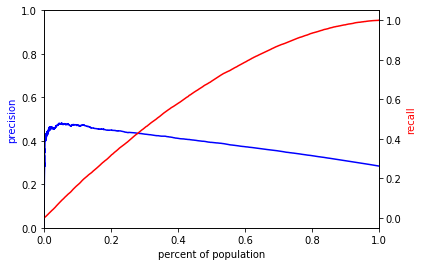

In [4]:
# Precision-recall curves 
pipeline.plot_precision_recall_n(y_test, scores)